### Introduction to Generating Simulated Host Galaxy Properties Using PZFlow, Alex Gagliano
(borrowed heavily from the PZFlow tutorials)

In [256]:
#If running in Collab, to switch to GPU, go to the menu and select Runtime -> Change runtime type -> Hardware accelerator -> GPU.

#In addition, uncomment and run the following code:
# !pip install pzflow

This notebook demonstrates building a normalizing flow with pzflow to learn the joint probability distribution of some multidimensional dataset.

You do not need to have any previous knowledge of normalizing flows to get started with pzflow, however if you are interested, here are some good sources:

*  Eric Jang's tutorial: part 1, part 2
*    Here is a comprehensive list of papers, blogs, videos, and packages
*    Two good intro papers using Coupling Layers: NICE, Real NVP
*    The paper on Neural Spline Couplings

First, import the required packages.

In [235]:
import jax.numpy as np
import matplotlib.pyplot as plt

import pzflow
from pzflow import Flow
from pzflow.bijectors import Chain, ColorTransform, InvSoftplus, StandardScaler, RollingSplineCoupling
from pzflow.examples import galaxy_data
from pzflow.distributions import Uniform, Joint, Normal
import pandas as pd

I've added a few rcparam commands to ensure our plots look great.

In [236]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

sns.set(font_scale=3.5)
sns.set_context("talk")
sns.set_palette("Set2")

sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 15
plt.rcParams['ytick.major.size'] = 15

plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['ytick.minor.size'] = 10
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.minor.width'] = 2

plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

Load in the sample dataset, which here is a subset of 100,000 galaxies from CosmoDC2.

In [237]:
data_full = pd.read_csv("../hostSims/DC2_subsample.tar.gz", index_col=0)

What does the data look like? 

In [238]:
data_full

morphology/totalSersicIndex  size_true  Mag_true_i_sdss_z0  \
13453452                     1.953625   0.102582          -20.503235   
9636239                      1.000000   0.125495          -16.411043   
22984308                     1.000000   0.207923          -17.154776   
23626513                     2.016766   0.040269          -17.172798   
9071643                      1.000000   0.055831          -13.970457   
...                               ...        ...                 ...   
277264                       1.000000   0.038189          -16.337240   
777638                       3.855846   0.020306          -13.539795   
27692864                     1.000000   0.149347          -16.826492   
5447545                      1.000000   0.075319          -14.870963   
3671109                      1.000000   0.110498          -15.577631   

          redshift  Mag_true_r_sdss_z0  Mag_true_g_sdss_z0    galaxy_id  \
13453452  0.976198          -20.260010          -19.718674  11314674806   
9636239   0.908719          -16.233278          -15.937250  10626811040   
22984308  0.804550          -16.970419          -16.669405   8001450987   
23626513  0.919570          -16.959549          -16.473295   8002093192   
9071643   0.558575          -13.825959          -13.523320   8000573870   
...            ...                 ...                 ...          ...   
277264    0.679244          -16.274628          -16.132912   9688432920   
777638    0.359458          -13.278637          -12.719821   9750156230   
27692864  0.714415          -16.798193          -16.745663   8938550123   
5447545   0.719588          -14.817184          -14.716454  10501028688   
3671109   0.662012          -15.506119          -15.396567   9813435457   

                 ra  baseDC2/sfr  morphology/totalEllipticity  \
13453452  67.490106     0.000000                     0.275744   
9636239   68.011337     0.010377                     0.030123   
22984308  65.396845     0.017524                     0.211989   
23626513  65.252543     0.003065                     0.625004   
9071643   65.054040     0.004139                     0.518045   
...             ...          ...                          ...   
277264    61.194209     0.005620                     0.342422   
777638    65.128064     0.010946                     0.086204   
27692864  65.948258     0.043868                     0.024179   
5447545   62.471789     0.048558                     0.127827   
3671109   67.385556     0.020709                     0.321412   

          Mag_true_z_sdss_z0  stellar_mass        dec  totalStarFormationRate  \
13453452          -20.669958  1.588438e+09 -43.824347            2.323016e+06   
9636239           -16.505833  2.225011e+06 -41.516076            3.455804e+07   
22984308          -17.266327  5.588776e+06 -37.831931            7.133745e+07   
23626513          -17.301256  7.070650e+06 -37.102827            1.261771e+04   
9071643           -14.024138  7.082511e+05 -38.092819            2.319504e+05   
...                      ...           ...        ...                     ...   
277264            -16.358604  9.515044e+06 -39.967169            6.006384e+04   
777638            -13.670223  6.810516e+05 -39.297474            5.258054e+02   
27692864          -16.831230  1.597176e+07 -39.398731            2.087925e+05   
5447545           -14.885720  8.239818e+05 -42.246451            5.709599e+04   
3671109           -15.602760  2.418629e+06 -40.974812            1.945782e+07   

          z_bin  
13453452      4  
9636239       4  
22984308      4  
23626513      4  
9071643       2  
...         ...  
277264        3  
777638        1  
27692864      3  
5447545       3  
3671109       3  

[100000 rows x 15 columns]

Let's rename a few of our properties and take the log of values that have large ranges. This helps the normalizing flow predict new values.

In [239]:
data_full['logSFRtot'] = np.log10(data_full['totalStarFormationRate'])
data_full['logmass'] = np.log10(data_full['stellar_mass'])

data_full['g']  = data_full['Mag_true_g_sdss_z0']
data_full['r']  = data_full['Mag_true_r_sdss_z0']
data_full['i']  = data_full['Mag_true_i_sdss_z0']
data_full['z']  = data_full['Mag_true_z_sdss_z0']

Because color is more predictive of redshift than brightness, calculate colors for each galaxy.

In [240]:
data_full['g-r'] = data_full['g'] - data_full['r']
data_full['r-i'] = data_full['r'] - data_full['i']
data_full['i-z'] = data_full['i'] - data_full['z']

data = data_full[['redshift', 'logSFRtot', 'morphology/totalSersicIndex', 'size_true',
        'logmass', 'g', 'r', 'i', 'z', 'g-r', 'r-i', 'i-z']]

Next, we have to scale each of the properties to have a mean 0 and variance unity. This helps PZflow more accurately learn the distribution of your dataset.

In [241]:
data = data.values
data[:, 2:] = (data[:, 2:] - data[:, 2:].mean(axis=0))/data[:, 2:].std(axis=0)
data = pd.DataFrame(data, columns=('redshift','logSFRtot','morphology/totalSersicIndex', 'size_true',
        'logmass', 'g', 'r', 'i', 'z', 'g-r', 'r-i', 'i-z'))

In this case, we're going to condition redshift and star formation rate (because these two properties are unphysically discrete in DC2) on all of our other properties.

To create the conditional flow, we have to provide
1. The names of the data columns
2. The bijector
3. The names of the conditional columns

In [242]:
conditional_columns = data.columns.drop(['redshift', 'logSFRtot'])

latent = Joint(Uniform([(-3,3)]), Normal(1))

means = np.array([0.5, data['logSFRtot'].mean()])
stds = np.array([1/5.9, data['logSFRtot'].std()]) #switched 1/6 to 1/5.9
bijector = Chain(
    StandardScaler(means, stds),
    RollingSplineCoupling(nlayers=2, n_conditions=10),
)
flow = Flow(
    data_columns = ("redshift", "logSFRtot"),
    conditional_columns = ('morphology/totalEllipticity', 'size_true',
        'logmass', 'g', 'r', 'i', 'z', 'g-r', 'r-i', 'i-z'),
    bijector = bijector,
    latent = latent,          
)

Time to construct the flow! 

In [243]:
flow = Flow(['redshift', 'logSFRtot'], bijector, conditional_columns=data.columns.drop(['redshift', 'logSFRtot']))

Now let's train it on our data.

In [244]:
losses = flow.train(data, epochs=80, verbose=True)

Training 80 epochs 
Loss:
2.6073
-0.5037
-1.1175
-1.2257
-1.2826
-1.3098
-1.3129
-1.3568
-1.3943
-1.4062
-1.4339
-1.3949
-1.4570
-1.4689
-1.4747
-1.4869
-1.4849
-1.4736
-1.5103
-1.5205
-1.5237


How does the training loss look?

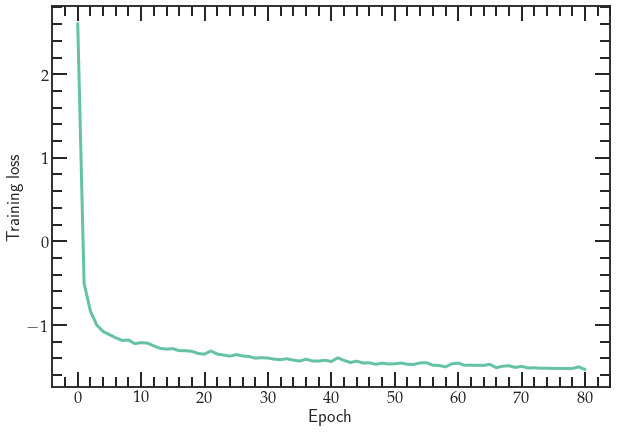

In [245]:
plt.figure(figsize=(10,7))
plt.plot(losses, lw=3)
plt.xlabel("Epoch");
plt.ylabel("Training loss");

It decreases roughly monotonically, and plateaus near the end of our training. That's great!

Next, let's sample from our normalizing flow. This function takes:

N: The number of times you'd like to generate samples for a set of conditioned properties. In this case, we want to generate one new redshift and SFR for each galaxy.
conditions: The conditional dataset.
seed: A random seed to reproduce this generated sample.

In [246]:
samples = flow.sample(1, conditions=data, seed=0)

How does our distribution of sampled redshifts compare with the original dataset?

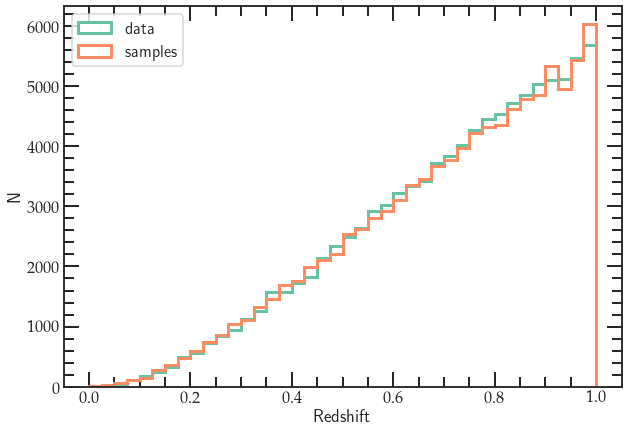

In [247]:
plt.figure(figsize=(10,7))
plt.hist(data['redshift'], range=(0, 1.0), bins=40, histtype='step', label='data', lw=3)
plt.hist(samples['redshift'], range=(0, 1.0), bins=40, histtype='step', label='samples', lw=3)
plt.xlabel("Redshift")
plt.ylabel("N")
plt.legend(loc='upper left')

Great! And does our color evolution with redshift still look physical? 

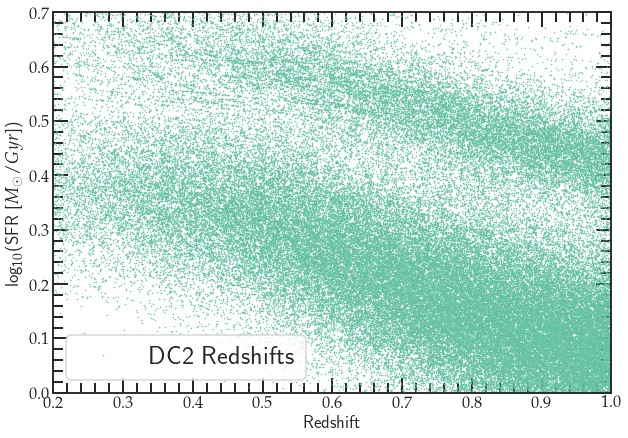

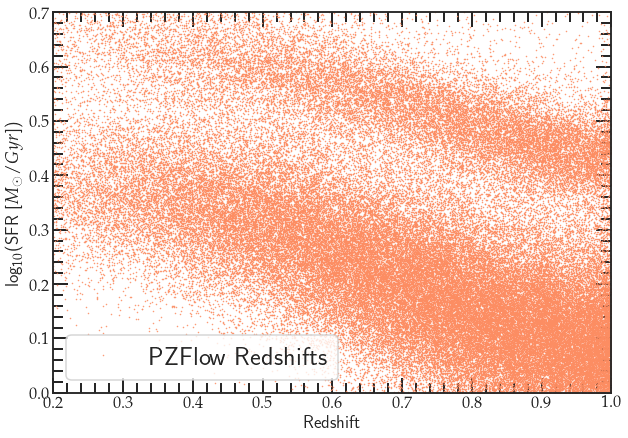

In [248]:
plt.figure(figsize=(10,7))
plt.plot(data_full['redshift'], data_full['g']-data_full['r'], 'o', ms=.5, label='DC2 Redshifts', c=sns.color_palette("Set2")[0])
plt.xlabel("Redshift")
plt.ylabel(r"log$_{10}$(SFR [$M_{\odot}/Gyr$])")
plt.xlim((0.2, 1.0));
plt.ylim((0, 0.7));
plt.legend(fontsize=26)

plt.figure(figsize=(10,7))
plt.plot(samples['redshift'],  data_full['g']-data_full['r'], 'o', ms=0.5, label='PZFlow Redshifts', c=sns.color_palette("Set2")[1])
plt.xlabel("Redshift")
plt.ylabel(r"log$_{10}$(SFR [$M_{\odot}/Gyr$])")
plt.xlim((0.2, 1.0));
plt.ylim((0, 0.7));
plt.legend(fontsize=26)

All good there. By how much did our redshifts change between the original table and the PZflow-sampled set?

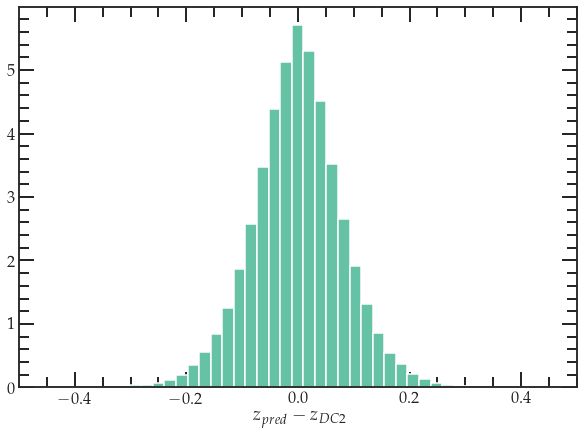

In [249]:
plt.figure(figsize=(10,7))
plt.hist(samples['redshift'].values - data_full['redshift'].values, bins=100, density=True);
plt.xlim((-0.5, 0.5))
plt.xlabel(r"$z_{pred} - z_{DC2}$");

All good here. Time to save our new values back to the original dataset.

In [250]:
data_full['PZflowredshift'] = samples['redshift'].values
data_full['PZflowSFRtot'] = 10**(samples['logSFRtot'].values)

del data_full['redshift']
del data_full['logSFRtot']

In [252]:
data_full_save = data_full[['galaxy_id','ra','dec',
          'PZflowredshift',
          'z_bin',
          'Mag_true_g_sdss_z0',
          'Mag_true_r_sdss_z0',
          'Mag_true_i_sdss_z0',
          'Mag_true_z_sdss_z0', 
          'morphology/totalSersicIndex',
          'size_true',
          'morphology/totalEllipticity',
          'stellar_mass',
          'PZflowSFRtot']]

Let's do some quality cuts just to make sure we didn't introduce any unphysical values in our dataset.

In [253]:
data_full_save_cut = data_full_save[(data_full_save['PZflowredshift']>=0.0) & (data_full_save['PZflowredshift']<=1.0)]
data_full_save_cut = data_full_save_cut[(data_full_save_cut['PZflowSFRtot'] > 1.e1) & (data_full_save_cut['PZflowSFRtot'] < 1.e10)]

How many galaxies were lost in this step?

In [254]:
#how many did we cut in quality cuts? 
print("%.2f%% of DC2 galaxies kept." % (len(data_full_save_cut)/len(data_full_save)*100))

99.15% of DC2 galaxies kept.


Very few. Time to save our final catalog of values.

In [255]:
data_full_save_cut.to_csv("../hostSims/DC2_subsample_fixedProperties.tar.gz")